# plot groundwater level

In [101]:
import numpy as np
import h5py as h5
import glob
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import datetime, timedelta
import pandas as pd
import ipdb

In [3]:
def batch_delta_to_time(origin, x, time_format, delta_format):
    y = []
    for ix in x:
        if delta_format == "hours":
            temp_y = origin + timedelta(hours=ix)
        elif delta_format == "days":
            temp_y = origin + timedelta(days=ix)
        elif delta_format == "minutes":
            temp_y = origin + timedelta(minutes=ix)
        elif delta_format == "weeks":
            temp_y = origin + timedelta(weeks=ix)
        elif delta_format == "seconds":
            temp_y = origin + timedelta(seconds=ix)
        elif delta_format == "microseconds":
            temp_y = origin + timedelta(microseconds=ix)
        elif delta_format == "milliseconds":
            temp_y = origin + timedelta(milliseconds=ix)
        else:
            print("Sorry, this naive program only solve single time unit")
        y.append(temp_y.strftime(time_format))
    y = np.asarray(y)
    return(y)

In [69]:
#input
model_dir = "/Users/shua784/Paraview/HFR/HFR_200x200x2_1w_bc/"
fname_model_origin = model_dir + "model_origin.txt"
fname_material_h5 = model_dir + "HFR_material_river.h5"
fname_pflotran_h5 = model_dir + "pflotran*.h5"

data_dir = "/Users/shua784/Dropbox/PNNL/Projects/Reach_scale_model/data/"
fname_mass1_coord = data_dir + "MASS1/coordinates.csv"

#output
out_dir = "/Users/shua784/Dropbox/PNNL/Projects/Reach_scale_model/Outputs/HFR_model_200x200x2_1w_bc/"
fig_wl = out_dir + 'wl/'
# output_dir = "/Users/song884/remote/reach/Outputs/HFR_100x100x5_6h_bc/"
# fig_dir = "/Users/song884/remote/reach/figures/HFR_100x100x5_6h_bc/wl/"
# data_dir = "/Users/song884/remote/reach/data/"

In [7]:
date_origin = datetime.strptime("2007-03-28 00:00:00", "%Y-%m-%d %H:%M:%S")
model_origin = np.genfromtxt(
    fname_model_origin, delimiter=" ", skip_header=1)

In [8]:
# read mass1 coordinates
section_coord = np.genfromtxt(
    fname_mass1_coord, delimiter=",", skip_header=1)
section_coord[:, 1] = section_coord[:, 1] - model_origin[0]
section_coord[:, 2] = section_coord[:, 2] - model_origin[1]
line1 = section_coord[0, 1:3] / 1000
line2 = section_coord[int(len(section_coord[:, 1]) / 2), 1:3] / 1000
line3 = section_coord[-1, 1:3] / 1000

line1_x = [line1[0]] * 2
line1_y = [line1[1] - 5, line1[1] + 5]
line2_x = [line2[0] - 5, line2[0] + 5]
line2_y = [line2[1]] * 2
line3_x = [line3[0] - 5, line3[0] + 5]
line3_y = [line3[1]] * 2

In [79]:
# # print group names
# for name in material_h5:
#     print(name)

# print both group and its member names
def printname(name):
    print(name)

In [80]:
    
# open file for reading
material_h5 = h5.File(fname_material_h5, "r") 
material_h5.visit(printname)

Materials
Materials/Cell Ids
Materials/Material Ids
Regions
Regions/Mass1_100
Regions/Mass1_100/Cell Ids
Regions/Mass1_100/Face Ids
Regions/Mass1_101
Regions/Mass1_101/Cell Ids
Regions/Mass1_101/Face Ids
Regions/Mass1_102
Regions/Mass1_102/Cell Ids
Regions/Mass1_102/Face Ids
Regions/Mass1_103
Regions/Mass1_103/Cell Ids
Regions/Mass1_103/Face Ids
Regions/Mass1_104
Regions/Mass1_104/Cell Ids
Regions/Mass1_104/Face Ids
Regions/Mass1_105
Regions/Mass1_105/Cell Ids
Regions/Mass1_105/Face Ids
Regions/Mass1_106
Regions/Mass1_106/Cell Ids
Regions/Mass1_106/Face Ids
Regions/Mass1_107
Regions/Mass1_107/Cell Ids
Regions/Mass1_107/Face Ids
Regions/Mass1_108
Regions/Mass1_108/Cell Ids
Regions/Mass1_108/Face Ids
Regions/Mass1_109
Regions/Mass1_109/Cell Ids
Regions/Mass1_109/Face Ids
Regions/Mass1_110
Regions/Mass1_110/Cell Ids
Regions/Mass1_110/Face Ids
Regions/Mass1_111
Regions/Mass1_111/Cell Ids
Regions/Mass1_111/Face Ids
Regions/Mass1_112
Regions/Mass1_112/Cell Ids
Regions/Mass1_112/Face Ids
Regi

limit_output extension: Maximum message size of 1000 exceeded with 20976 characters

In [23]:
# dset_cellid = material_h5['Materials/Cell Ids']

In [29]:
# dset_cellid[0:10]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int32)

In [22]:
# dset_cellid.shape # dimension
# dset_cellid.dtype
# dset_cellid.attrs

<Attributes of HDF5 object at 4597524024>

In [42]:
all_h5 = glob.glob(fname_pflotran_h5) # find all "pflotran*.h5" files
all_h5 = np.sort(all_h5)

input_h5 = h5.File(all_h5[0], "r")

In [43]:
input_h5.visit(printname)

Coordinates
Coordinates/X [m]
Coordinates/Y [m]
Coordinates/Z [m]
Provenance
Provenance/PETSc
Provenance/PETSc/detail_petsc_config
Provenance/PETSc/detail_petsc_parent
Provenance/PETSc/detail_petsc_status
Provenance/PFLOTRAN
Provenance/PFLOTRAN/detail_pflotran_diff
Provenance/PFLOTRAN/detail_pflotran_fflags
Provenance/PFLOTRAN/detail_pflotran_parent
Provenance/PFLOTRAN/detail_pflotran_status
Provenance/PFLOTRAN/pflotran_compile_date_time
Provenance/PFLOTRAN/pflotran_compile_hostname
Provenance/PFLOTRAN/pflotran_compile_user
Provenance/PFLOTRAN/pflotran_input_file
Time:  3.24000E+04 h
Time:  3.24000E+04 h/Liquid X-Flux Velocities
Time:  3.24000E+04 h/Liquid Y-Flux Velocities
Time:  3.24000E+04 h/Liquid Z-Flux Velocities
Time:  3.24000E+04 h/Liquid_Pressure [Pa]
Time:  3.24000E+04 h/Liquid_Saturation
Time:  3.24000E+04 h/Material_ID
Time:  3.24000E+04 h/Total_Tracer [M]
Time:  3.24000E+04 h/Total_Tracer_Age [M]
Time:  3.24000E+04 h/Tracer_Age [h-molar]
Time:  3.25200E+04 h
Time:  3.25200

limit_output extension: Maximum message size of 1000 exceeded with 6735 characters

In [44]:
x_grids = list(input_h5["Coordinates"]['X [m]'])
y_grids = list(input_h5["Coordinates"]['Y [m]'])
z_grids = list(input_h5["Coordinates"]['Z [m]'])
input_h5.close()

dx = np.diff(x_grids)
dy = np.diff(y_grids)
dz = np.diff(z_grids)

nx = len(dx)
ny = len(dy)
nz = len(dz)

# x,y,z coordinates at cell center
x = x_grids[0] + np.cumsum(dx) - 0.5 * dx[0]
y = y_grids[0] + np.cumsum(dy) - 0.5 * dy[0]
z = z_grids[0] + np.cumsum(dz) - 0.5 * dz[0]

# create grids--a list of arrays based nx, ny, nz
grids = np.asarray([(x, y, z) for z in range(nz)
                    for y in range(ny) for x in range(nx)])

In [94]:
grids[0:9]

array([[0, 0, 0],
       [1, 0, 0],
       [2, 0, 0],
       [3, 0, 0],
       [4, 0, 0],
       [5, 0, 0],
       [6, 0, 0],
       [7, 0, 0],
       [8, 0, 0]])

In [82]:
# time_index[0:2]
# list(material_h5['Regions'].keys())
list(material_h5["Regions"][i_region]["Cell Ids"])

[4928198,
 4928498,
 5018199,
 5018199,
 5018497,
 5108497,
 5198497,
 5198497,
 5288497,
 5288497,
 5378497,
 5378497,
 5378497]

In [84]:
# open file for reading
material_h5 = h5.File(fname_material_h5, "r") 
# read river cell ids
river_cells = []
for i_region in list(material_h5['Regions'].keys()):
    river_cells = np.append(river_cells, np.asarray(
        list(material_h5["Regions"][i_region]["Cell Ids"])))
river_cells = np.unique(river_cells).astype(int)
river_cells = river_cells - 1  # need minus 1 as python index started with 0
# label river cells in x-y plane with '1'
yx_river = np.asarray([np.nan] * (ny * nx)).reshape(ny, nx) # initialize ny*nx array with nan value
for icell in river_cells:
    yx_river[grids[icell, 1], grids[icell, 0]] = 1
    
material_h5.close()

In [100]:
# list(enumerate(groups))
float(itime[7:18])

32400.0

/Users/shua784/Paraview/HFR/HFR_200x200x2_1w_bc/pflotran_200x200x2_1w_bc.h5
Time:  3.24000E+04 h


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'V'
  s)


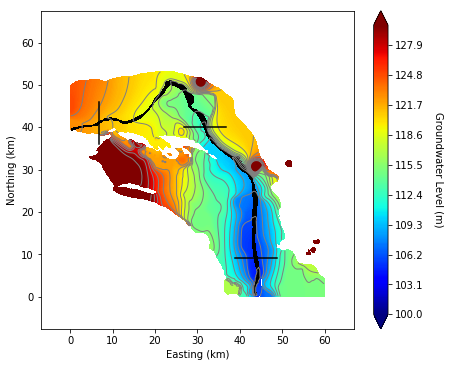

In [107]:
# loop over pflotran*.h5 files
for i_h5 in all_h5:
    print(i_h5)
    input_h5 = h5.File(i_h5, "r")

    groups = list(input_h5.keys()) # create a list with group names
    time_index = [s for s, s in enumerate(groups) if "Time:" in s] # enumerate returns its index (index, string)

    # loop over time step
    for itime in time_index[0:1]:
        
#         ipdb.set_trace()
        
        print(itime)
        # initialize total head
        temp_wl = np.asarray([np.nan] * (ny * nx)).reshape(ny, nx)
        # read pressure
        temp_pressure = np.asarray(
            list(input_h5[itime]["Liquid_Pressure [Pa]"]))
        # convert p to head
        temp_head = (temp_pressure - 101325) / 997.16 / 9.8068
        for ix in range(nx):
            for iy in range(ny):
                positive_head_index = np.where(temp_head[ix, iy, :] > 0)[0] # take the first positive head
                if (len(positive_head_index) > 0): # if positive head exists, then caculate total head
                    iz = positive_head_index[0]
                    temp_wl[iy, ix] = temp_head[ix, iy, iz] + z[iz]
        
#         ipdb.set_trace()
        
        real_itime = batch_delta_to_time(date_origin, [float(
            itime[7:18])], "%Y-%m-%d %H:%M:%S", "hours")
        real_itime = str(real_itime[0])
        fig_name = fig_wl + real_itime + ".png"
        gs = gridspec.GridSpec(1, 1)
        fig = plt.figure()
        ax1 = fig.add_subplot(gs[0, 0])
        ax1.plot(line1_x, line1_y, "black")
        ax1.plot(line2_x, line2_y, "black")
        ax1.plot(line3_x, line3_y, "black")
        cf1 = ax1.contourf(x / 1000, y / 1000, temp_wl,
                           cmap=plt.cm.jet,
                           levels=np.arange(100, 130.1, 0.1),
                           vmin=100,
                           vmax=130,
                           extend="both",
                           V=np.arange(100, 130.1, 5)
                           )
        cf2 = ax1.contour(x / 1000, y / 1000, temp_wl,
                          colors="grey",
                          levels=np.arange(100, 130.1, 1.5),
                          linewidths=1,
                          vmin=100,
                          vmax=130)

        ax1.set_xlabel("Easting (km)")
        ax1.set_ylabel("Northing (km)")
        ax1.set_aspect("equal", "datalim")
        ax1.set_xlim([np.min(x_grids) / 1000, np.max(x_grids) / 1000])
        ax1.set_ylim([np.min(x_grids) / 1000, np.max(x_grids) / 1000])
        ax1.set_aspect("equal", "datalim")
        cb1 = plt.colorbar(cf1, extend="both")  # ,
#                           orientation="horizontal", shrink=0.8, aspect=25)
        cb1.ax.set_ylabel("Groundwater Level (m)", rotation=270, labelpad=20)
        fig.tight_layout()
        cf3 = ax1.contourf(x / 1000, y / 1000, yx_river, colors="black")
        fig.set_size_inches(6.5, 5.5)

In [78]:
        fig.savefig(fig_name, dpi=600, transparent=True)
        plt.close(fig)
input_h5.close()